In [1]:
import pandas as pd
import numpy as np

import pickle
import sys
sys.path.append("..")

from src.process import *
from src.plot import *
from gensim.models import LdaModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Loading in Data

In this NB I focused on analyzing the processed data, but I included the code for loading and preprocessing the original data for reproducibility

In [15]:
df = pd.read_csv('../data/dataset/train.csv') # Read the original data
df_concat = load_csvs_from_dir('../data/more_feats/') # Separate csvs that need to be concatenated

In [16]:
# Restructuring DFs

df.columns = [x.lower() for x in df.columns] # For ease of use
df_concat.rename(columns={'name': 'title'}, inplace=True) # Rename for joining on original dataframe

In [17]:
# Merge new info to original DF for new features

merged_df = df.merge(df_concat, on='title', how='left')
merged_df = merged_df.drop_duplicates('title') # In case there are multiple matches in the right DF

In [26]:
# Check to see data overlap in merged

merged_df.main_category.notna().sum()

3322

# Data Inspection

Inspect missing values, duplicates, dirty formating, etc.

In [13]:
df.columns

Index(['product_id', 'title', 'bullet_points', 'description',
       'product_type_id', 'product_length'],
      dtype='object')

In [14]:
# Check to see that product_id is a unique identifier for the dataset

print(f"{round((df.product_id.unique().shape[0] / df.shape[0]) * 100)}% of data covered by Product ID")

100% of data covered by Product ID


In [15]:
# Check for duplicated data

print(f"{df.duplicated().sum()} duplicates in dataset")

0 duplicates in dataset


In [16]:
# Check percent null values in dataset

for col in df.columns:
    no_na = df[col].isna().sum()
    pct_na = no_na / df.shape[0]
    print(f"Column {col} has {no_na} null values, {round(pct_na * 100)}% of total data")

Column product_id has 0 null values, 0% of total data
Column title has 12 null values, 0% of total data
Column bullet_points has 837364 null values, 37% of total data
Column description has 1157381 null values, 51% of total data
Column product_type_id has 0 null values, 0% of total data
Column product_length has 0 null values, 0% of total data


We have a serious instance of missing data in bullet_points and description, we need to determine the type of missingness. Is it missing completely at random? Is it tied in some way to the product type? If it's not, we need to determine the best course of action for imputation.

In [17]:
# Check out how many instances our main categorical variable has

print(f"{df.product_type_id.nunique()} categories in data")

12907 categories in data


Huge number of categories, i.e. high cardinality,  need to figure out best method for representing this data in a simplified way.

In [18]:
# Get the number of records grouped by the product type

grouped = df.groupby("product_type_id").count()
grouped['product_id'].describe()

count     12907.000000
mean        174.300612
std        1537.829375
min           1.000000
25%           3.000000
50%          11.000000
75%          53.000000
max      121199.000000
Name: product_id, dtype: float64

First we need to simplify the categories. Because most of my analysis will consist of text data, due to size and time constraints I will need to take a much smaller sample of the dataset. I will take a stratified sample based on the simplified categories to make sure it is a representative sample. 

## Simplifying Categories

Initially, I wanted to look and see if we can use relative frequencies to group less frequent categories together. I used entropy to measure how much of the complexity of the dataset we were capturing by keeping the `n` most frequent classes to decide what the appropriate value for `n` would be.  

<Axes: ylabel='Frequency'>

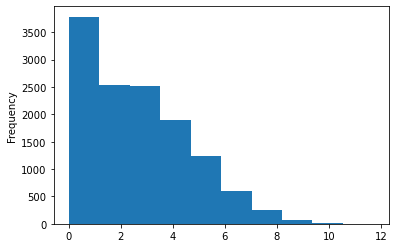

In [19]:
df.product_type_id.value_counts().apply(np.log).plot(kind='hist')

In [20]:
# We want to find how many classes represent what pct of the data
# i.e. how many classes do we need to represent 50% of the data?

grouped_counts = grouped["product_id"].sort_values(ascending=False)
n = df.shape[0]
sorted_counts = grouped_counts.values

pcts = [0.5, 0.75, 0.9, 0.99]

for pct in pcts:
    running_ct = 0
    n_classes = 0
    for count in sorted_counts:
        running_ct += count
        n_classes += 1
        current_pct = running_ct / n
        if current_pct >= pct:
            print(f"Number of classes to reach {round(pct * 100)}%: {n_classes}")
            break
        else:
            continue

Number of classes to reach 50%: 137
Number of classes to reach 75%: 628
Number of classes to reach 90%: 1870
Number of classes to reach 99%: 6601


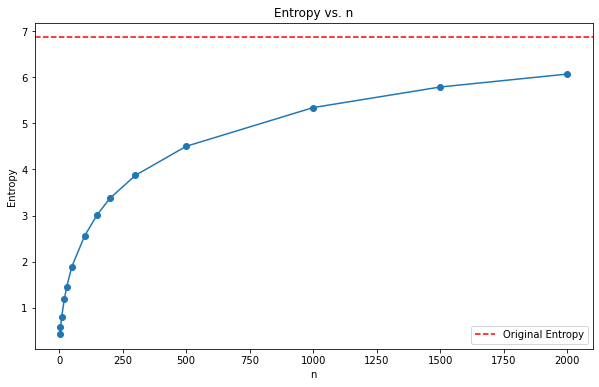

In [21]:
# Possible values for the number of most frequent categories to keep

ns = [3, 5, 10, 20, 30, 50, 100, 150, 200, 300, 500, 1000, 1500, 2000]

calculate_entropy_curve(df, 'product_type_id', ns)

In [22]:
df = frequency_group_cat_variable(df, 'product_type_id', 100)
merged_df = frequency_group_cat_variable(merged_df, 'product_type_id', 100)

In [23]:
df['grouped_product_type_id'] = df.grouped_product_type_id.astype(str)

In [24]:
# Take 10% of the original data
sample = stratified_sample(df, 'grouped_product_type_id', 0.1)
sample_more_features = merged_df[merged_df.main_category.notna()]

# Data Preprocessing
All this preprocessing I ran on a kaggle kernel, but this is the code itself

In [ ]:
run_feature_extraction(sample)

In [ ]:
run_feature_extraction(sample_more_features)

In [ ]:
sample_more_features['rating'] = sample_more_features.ratings.apply(process_rating)
sample_more_features['n_ratings'] = sample_more_features.no_of_ratings.apply(process_rating)

In [ ]:
sample_more_features['discount'] = sample_more_features.discount_price.apply(process_price)
sample_more_features['actual'] = sample_more_features.actual_price.apply(process_price)

In [ ]:
sample_more_features['discount_pct'] = ((sample_more_features['actual'] - sample_more_features['discount']) / sample_more_features['actual']) * 100

Loading in my preprocessed dfs to continue the analysis in this NB

In [2]:
sample = pd.read_csv('../data/preprocessed_sample.csv')
sample_more_features = pd.read_csv('../data/sample_extra_feats.csv')

# Topic Modeling

To find the proper number of topics, we calculate the coherence for a range of ns. We then choose the n_topics that maximizes the coherence. For this cell I will only run it on a small subset, but the original graph is included in the presentation.

In [ ]:
n_topics = calculate_topic_coherence(list(x.split() for x in sample.all_text.values[:1000]), 2, 30, n=2)

We see a peak at 1 topic, but another significant peak at around 24 topics. I chose 24 topics because 1 topic would be nonsensical.


In [ ]:
texts = [x.split() for x in sample.all_text.values]

# Create a dictionary and corpus from preprocessed texts
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = train_lda(corpus, dictionary, n_topics)

I'm loading in my pretrained model from the whole dataset

In [3]:
lda_model = LdaModel.load('../models/lda.model')

In [11]:
display_lda_topics(lda_model, n_words=10)

Topic 0:
sticker, vinyl, skin, stick, surface, wall, mirror, window, adhesive, tape

Topic 1:
car, cover, protection, uv, sun, ul, vehicle, lens, body, resistant

Topic 2:
NUMBER, case, printed, brake, product, pack, may, rakhi, different, query

Topic 3:
wall, art, room, frame, canvas, home, decor, print, painting, quality

Topic 4:
cat, cake, chocolate, ice, und, mold, science, cube, world, candy

Topic 5:
glass, screen, protector, tempered, NUMBER, guard, edge, scratch, clear, touch

Topic 6:
bag, leather, card, pocket, NUMBER, SIZE, wallet, strap, travel, carry

Topic 7:
shoe, comfort, woman, foot, men, comfortable, heel, leather, sport, sandal

Topic 8:
shower, towel, bathroom, balloon, bath, soap, star, sink, volume, foil

Topic 9:
NUMBER, x, COLOR, inch, product, curtain, cm, SIZE, Size, length

Topic 10:
wear, woman, look, saree, casual, fabric, fashion, kurta, cotton, type

Topic 11:
table, kitchen, steel, stainless, storage, NUMBER, home, wood, set, easy

Topic 12:
case, cove

We can see many topics capture significant clusters in the data, others do not so we combine them into Misc

In [6]:
topic_labels = {
    0: 'Sticker',
    1: 'Car',
    2: 'Misc',
    3: 'Art',
    4: 'Sweets',
    5: 'Glass/Screens',
    6: 'Bags',
    7: 'Shoes',
    8: 'Bathroom',
    9: 'Sizes',
    10: 'Womens Fashion',
    11: 'Kitchen',
    12: 'Phone Case',
    13: 'Children',
    14: 'Gifts/Party Goods',
    15: 'Electronics',
    16: 'Misc',
    17: 'Misc',
    18: 'Womens Fashion',
    19: 'Watches',
    20: 'Gardening',
    21: 'Shirts',
    22: 'Jewelry',
    23: 'Design'
}

In [ ]:
# This takes the predictions from the lda model and adds them as an lda_topic column and an lda_score column

sample = predict_lda_topics(lda_model, sample, 'all_text')
sample_more_features = predict_lda_topics(lda_model, sample_more_features, 'all_text')

In [8]:
sample['topic_name'] = sample['lda_topic'].apply(lambda x: topic_labels[x])
sample_more_features['topic_name'] = sample_more_features['lda_topic'].apply(lambda x: topic_labels[x])

# Doc2Vec

Here again I am loading in my preprocessed vectors to save computational time in this NB, but have included the code for reference

In [ ]:
doc2vec_model = train_doc2vec_model(sample.all_text.values, vector_size=100, epochs=40, )

In [ ]:
texts = [x.split() for x in sample.all_text.values]
vecs = transform_to_doc2vec_vectors(texts, doc2vec_model, batch_size=1000)

In [3]:
vecs = pickle.load(open('../data/vecs.pkl', 'rb'))

Make sure the dimensionalities line up

In [4]:
vecs.shape[0] == sample.shape[0]

True

## Vector Clustering

We use the Elbow method to find the appropriate amount of clusters based on the word vectors (in reality, it is measuring distortion score (SSE) for the given number of clusters

In [ ]:
plot_elbow_curve(range(2, 20), vecs)

/Users/liamgeron/anaconda3/envs/quility/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/liamgeron/anaconda3/envs/quility/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Apply clustering with K-means
n_clusters = 4  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(projected_vecs)

## Vector Plotting and Projection

In [3]:
doc2vec_model = Doc2Vec.load('../models/doc2vec_40_epochs.model')

In [4]:
texts = [x.split() for x in sample_more_features.all_text.values]
vecs_addtnl = transform_to_doc2vec_vectors(texts, doc2vec_model, batch_size=1000)
projected_vecs_addtnl = project_vectors(vecs_addtnl, n_dimensions=2, scaled=True)

100%|█████████████████████████████████████████████| 4/4 [00:37<00:00,  9.50s/it]


In [4]:
projected_vecs = project_vectors(vecs, n_dimensions=2, scaled=True)

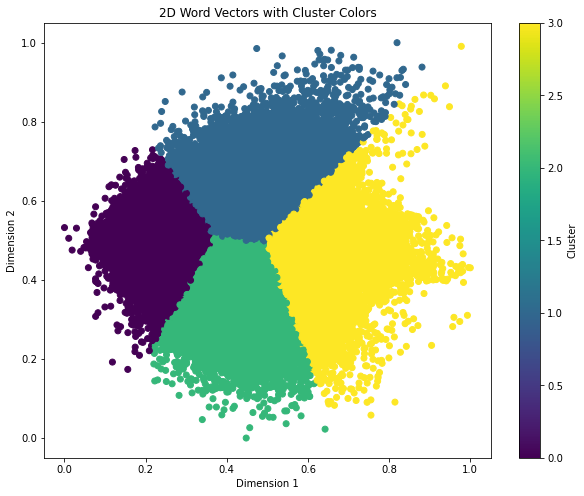

In [7]:
plot_word_vectors_with_labels(projected_vecs, cluster_labels)

We can also look at how the topic modeling corresponds with the word vectors

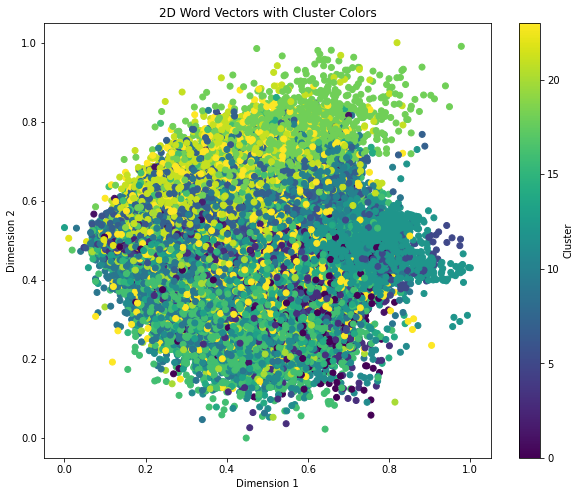

In [9]:
plot_word_vectors_with_labels(projected_vecs, sample.lda_topic.values)

In [16]:
sample_more_features.main_category.astype('category').cat.codes

0       15
1        0
2       17
3       17
4       13
        ..
3317    10
3318    13
3319    14
3320    13
3321     2
Length: 3322, dtype: int8

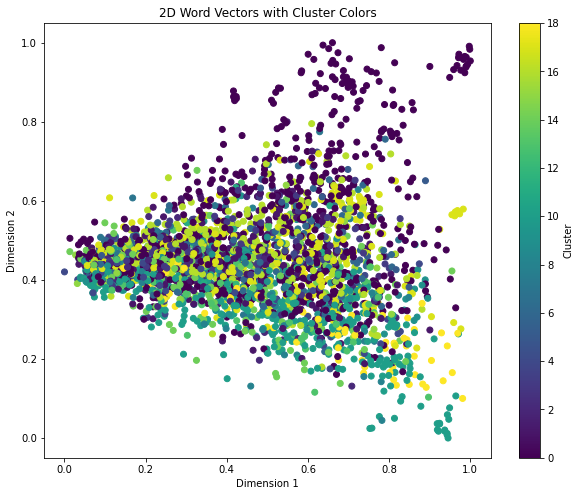

In [20]:
plot_word_vectors_with_labels(projected_vecs_addtnl, sample_more_features.main_category.astype('category').cat.codes)

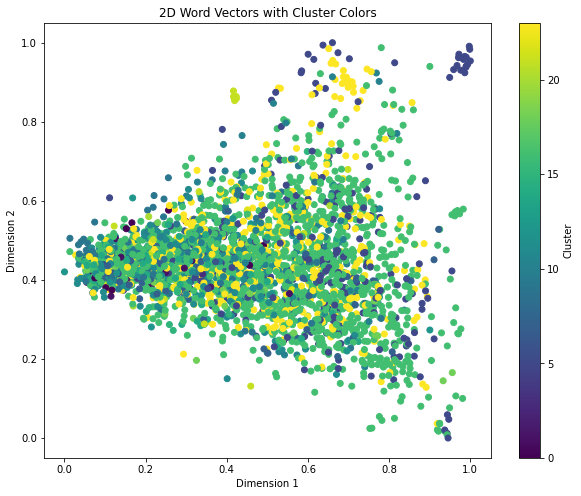

In [18]:
plot_word_vectors_with_labels(projected_vecs_addtnl, sample_more_features.lda_topic)

In [10]:
# Find the most informative words for each cluster

informative_words = extract_most_informative_words(sample.all_text.values, cluster_labels, num_keywords=5)

In [3]:
# Find the most informative words for each topic

informative_topic_words = extract_most_informative_words(sample.all_text.values, sample.lda_topic.values, num_keywords=5)

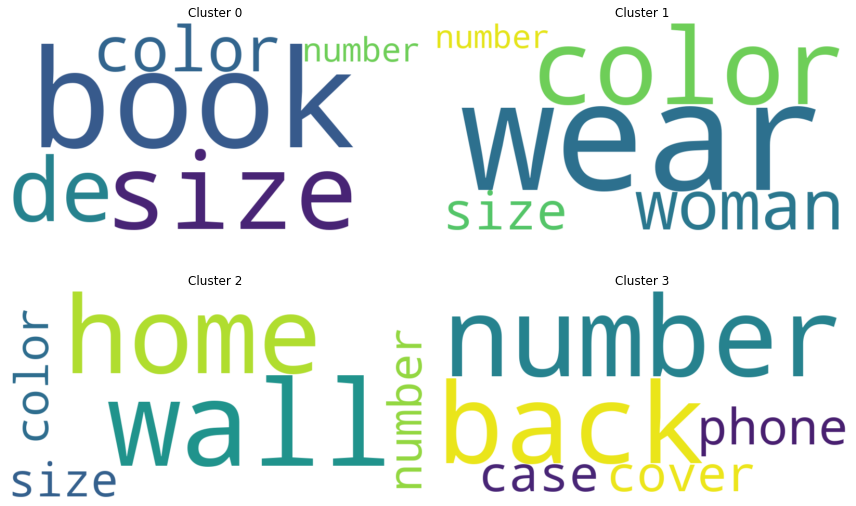

In [12]:
plot_word_clouds(informative_words)

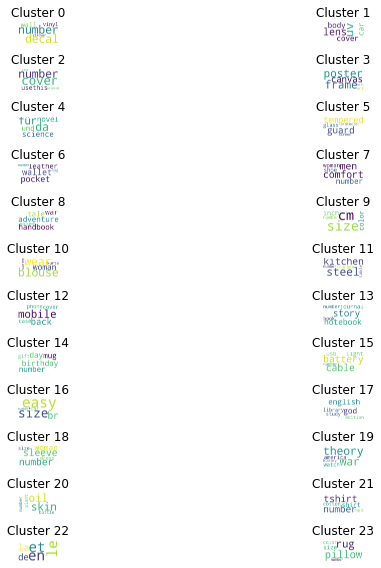

In [4]:
plot_word_clouds(informative_topic_words)

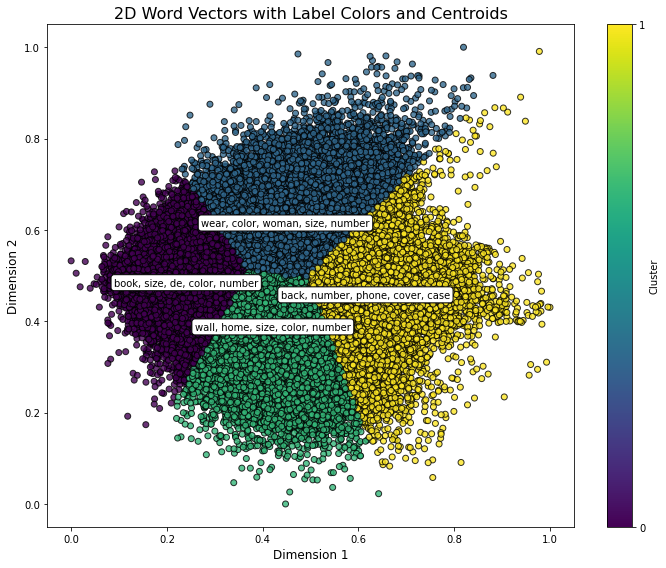

In [13]:
plot_word_vectors_with_clusters_and_centroids(projected_vecs, cluster_labels, informative_words)

# EDA

Now that we've derived all these features from the text data, let's try and visualize how they work together

In [2]:
sample = pd.read_csv('../data/preprocessed_sample.csv')
sample_more_features = pd.read_csv('../data/sample_extra_feats.csv')

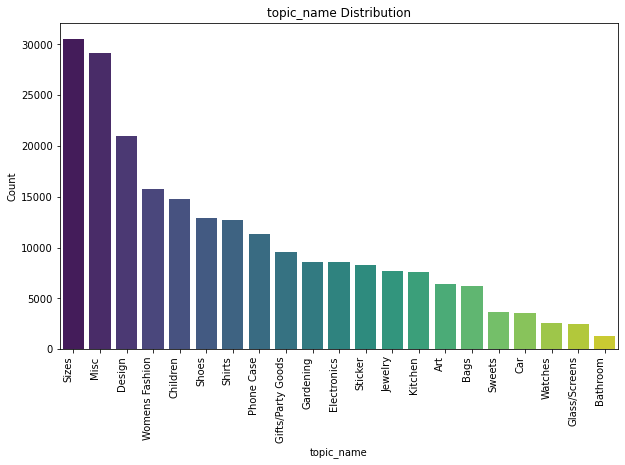

<module 'matplotlib.pyplot' from '/Users/liamgeron/anaconda3/envs/quility/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [5]:
plot_categorical_distribution(sample, 'topic_name')

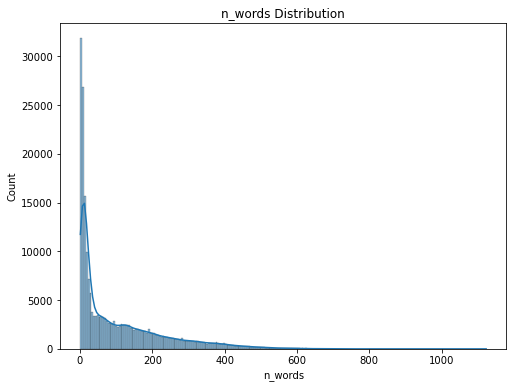

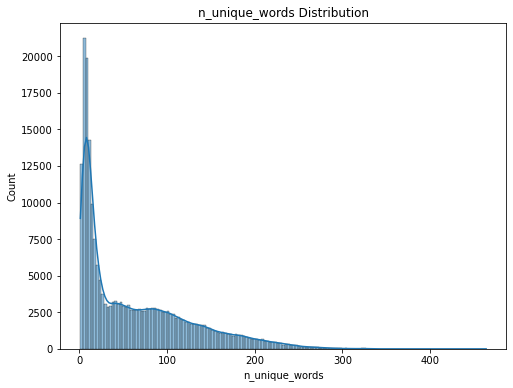

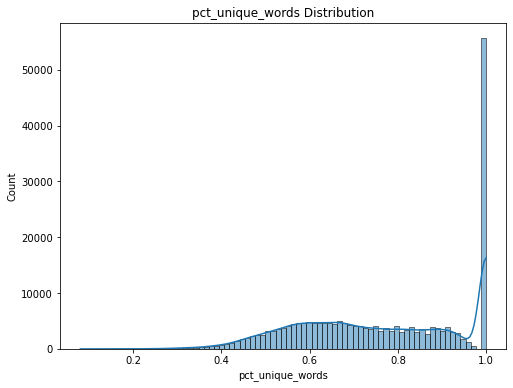

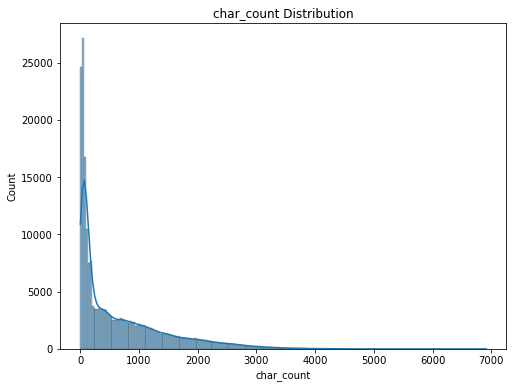

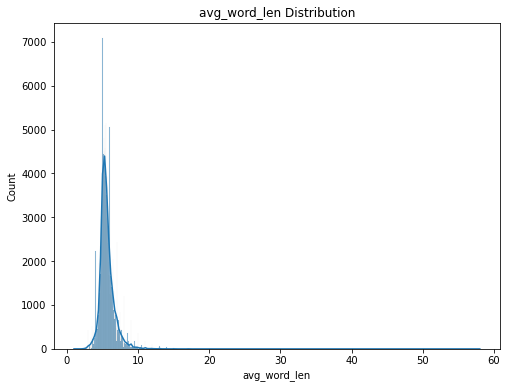

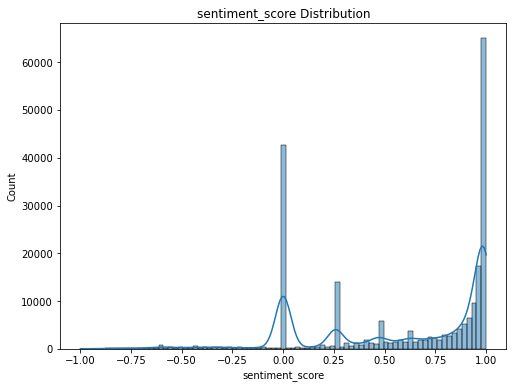

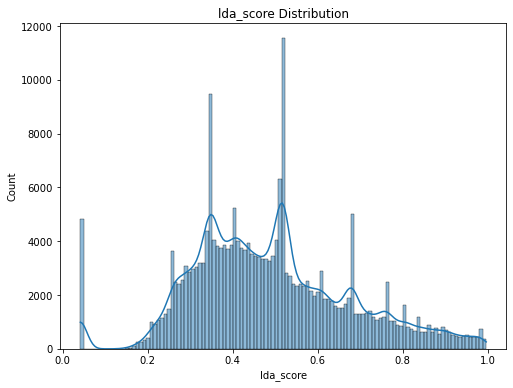

<module 'matplotlib.pyplot' from '/Users/liamgeron/anaconda3/envs/quility/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [5]:
plot_numerical_distribution(sample, ['n_words', 'n_unique_words', 'pct_unique_words', 'char_count', 
                                     'avg_word_len', 'sentiment_score', 'lda_score'])

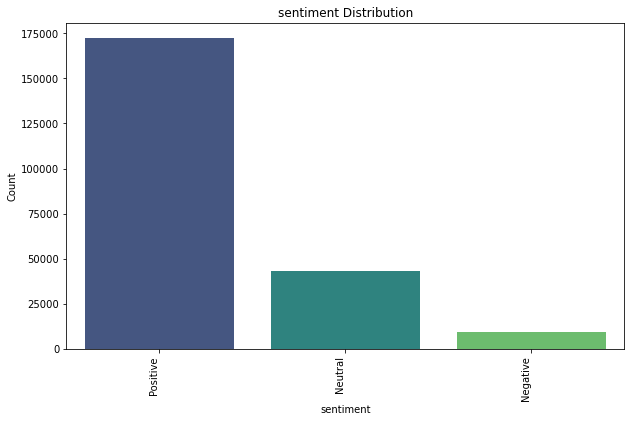

<module 'matplotlib.pyplot' from '/Users/liamgeron/anaconda3/envs/quility/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [6]:
plot_categorical_distribution(sample, 'sentiment')

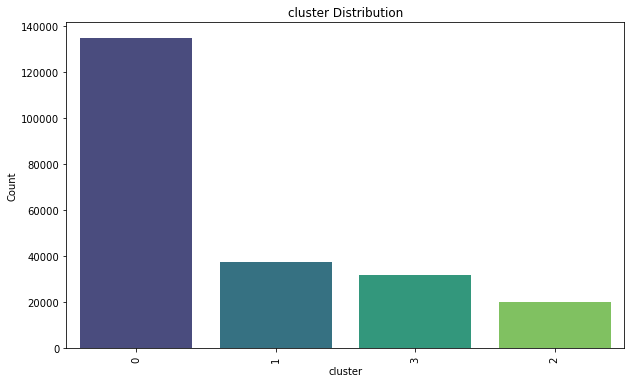

<module 'matplotlib.pyplot' from '/Users/liamgeron/anaconda3/envs/quility/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [7]:
plot_categorical_distribution(sample, 'cluster')

In [6]:
numerical_cols = ['product_length', 'n_unique_words', 'pct_unique_words', 'char_count', 'avg_word_len', 'sentiment_score']

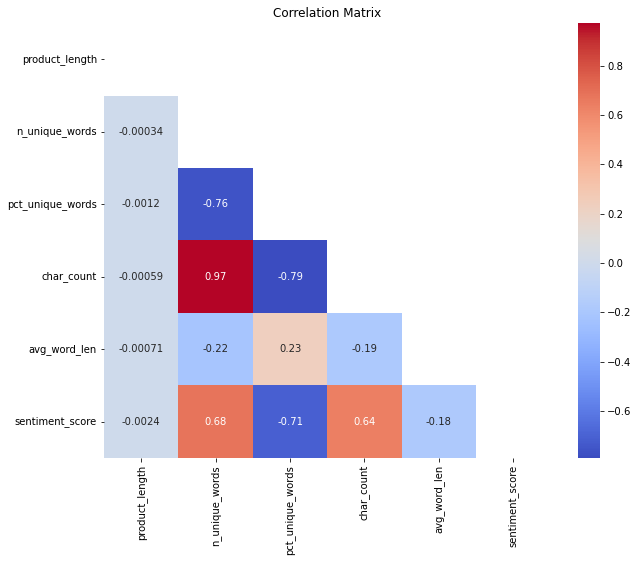

<module 'matplotlib.pyplot' from '/Users/liamgeron/anaconda3/envs/quility/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [8]:
plot_correlation_matrix(sample, numerical_cols)

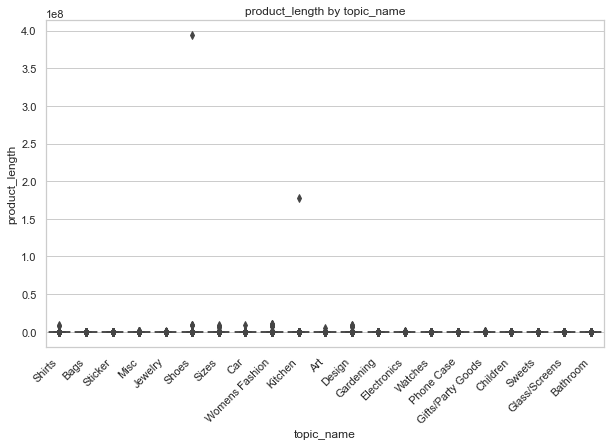

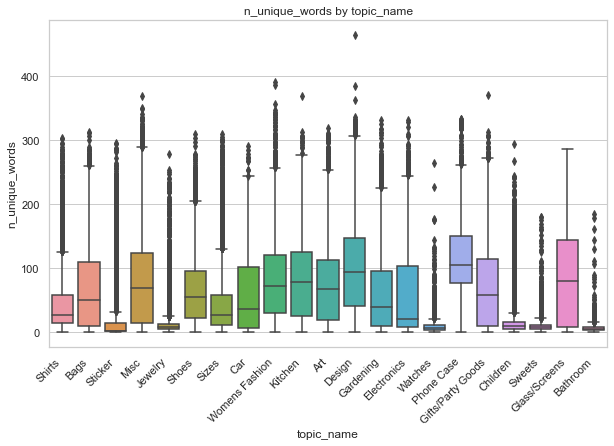

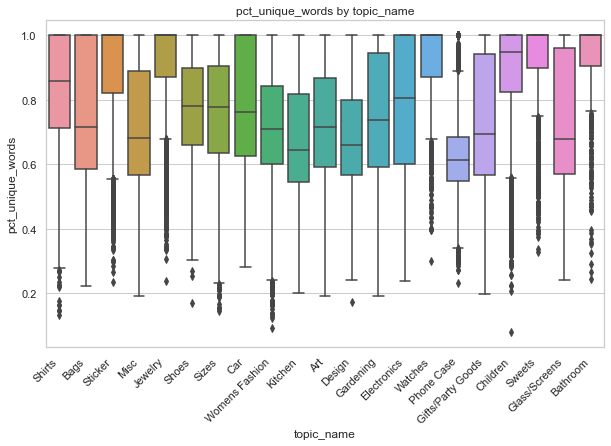

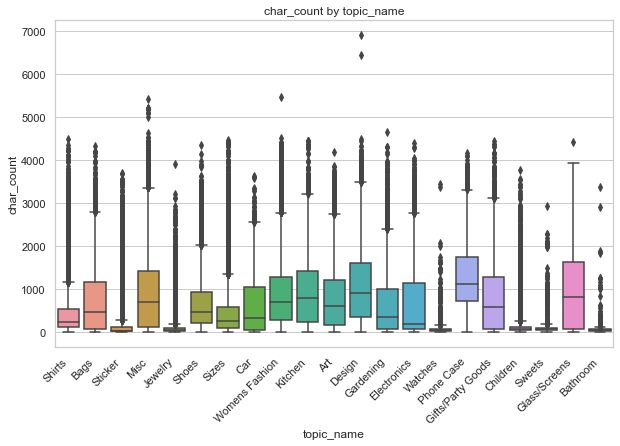

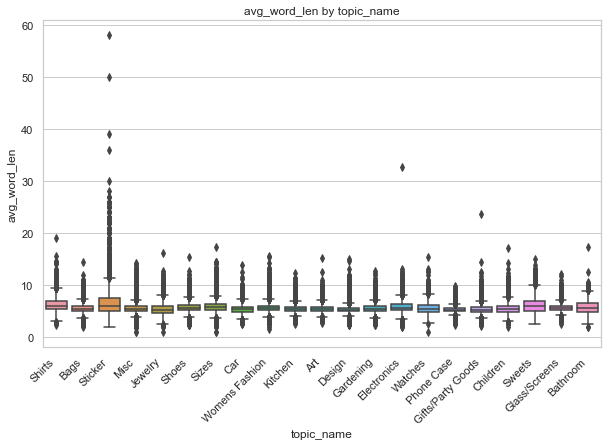

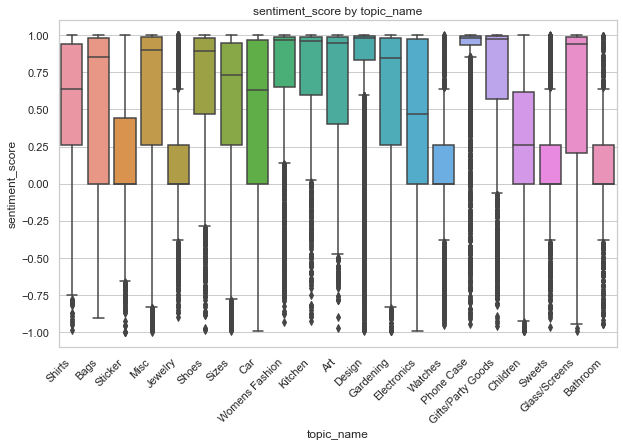

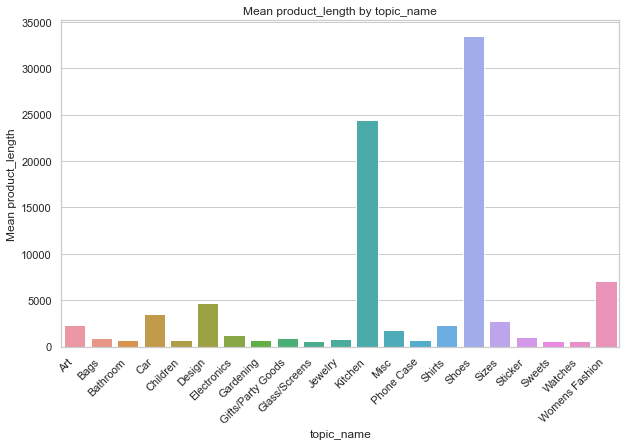

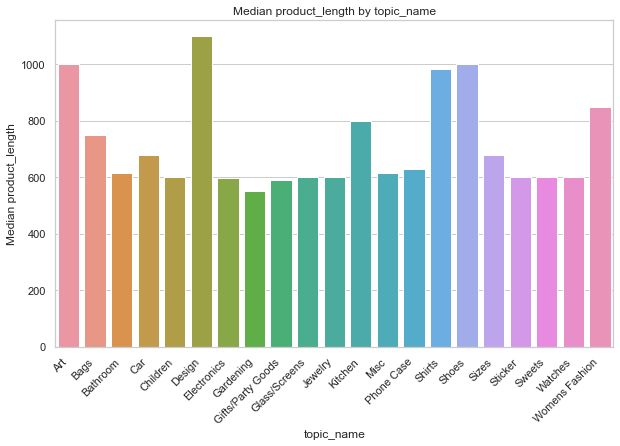

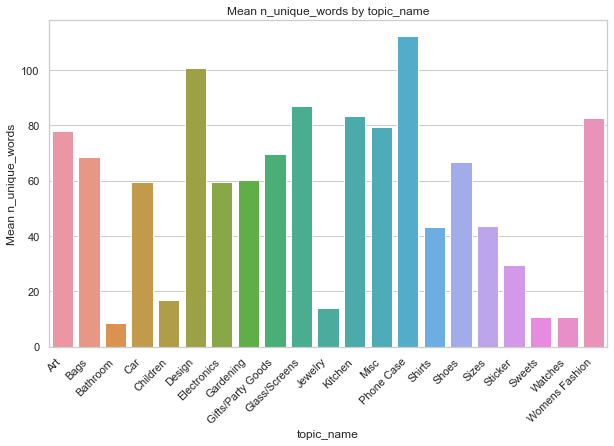

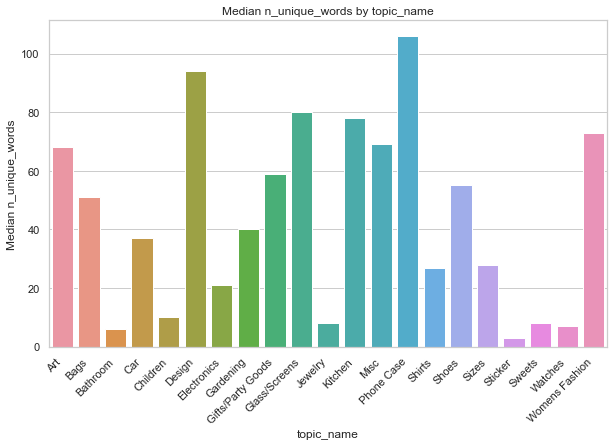

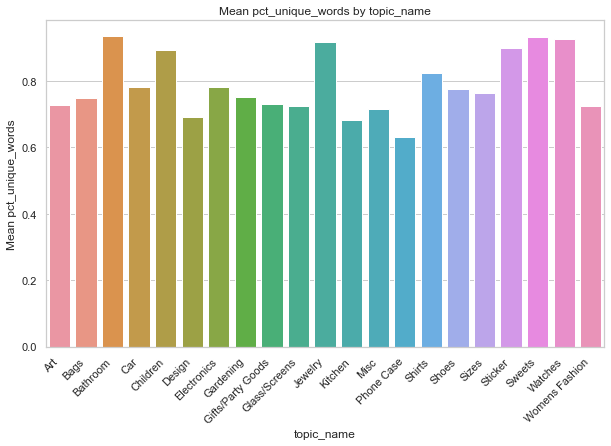

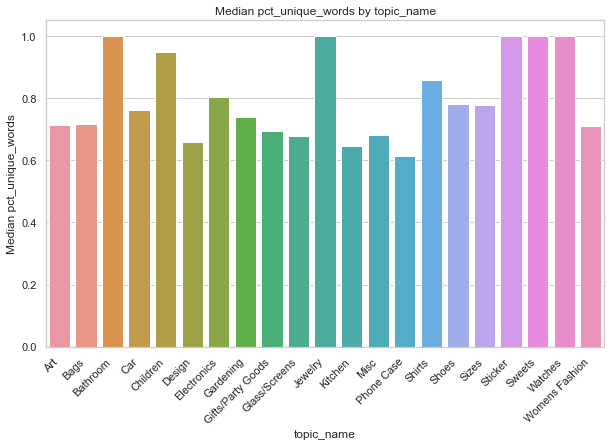

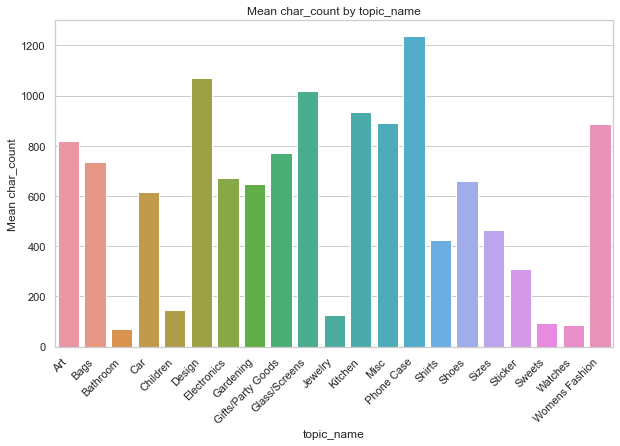

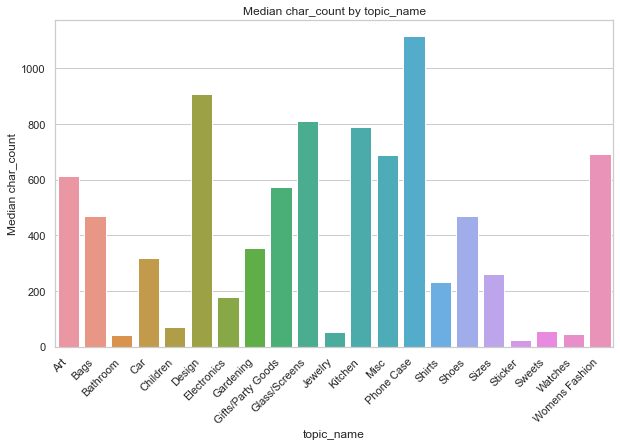

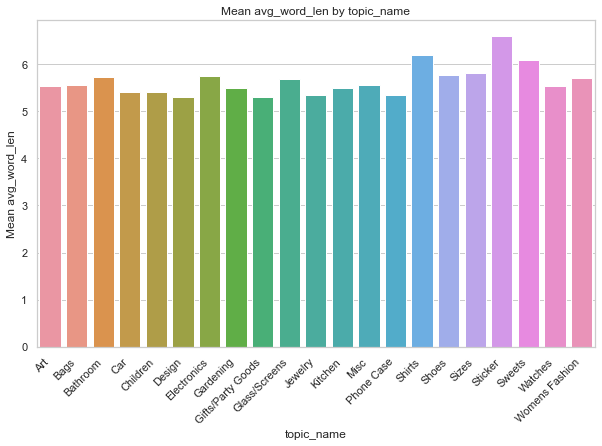

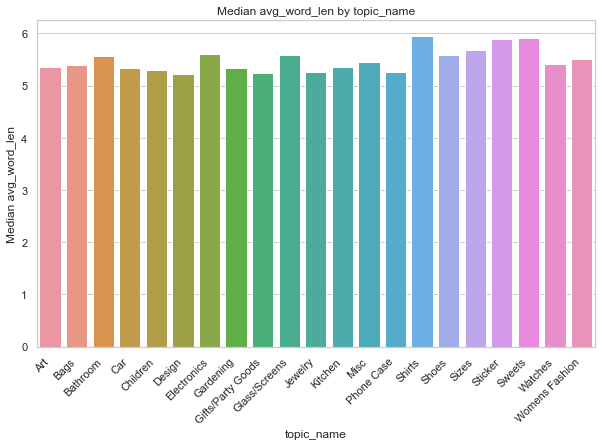

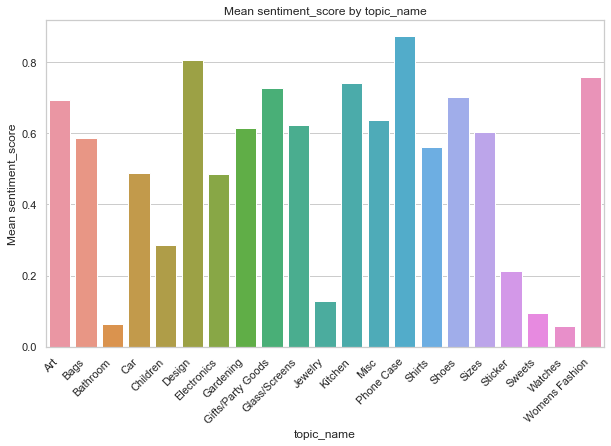

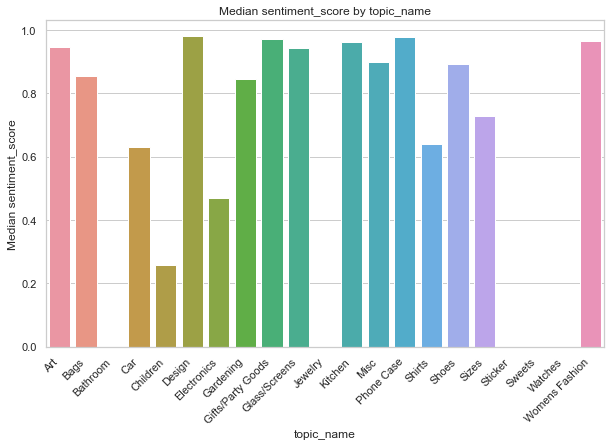

<module 'matplotlib.pyplot' from '/Users/liamgeron/anaconda3/envs/quility/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [7]:
plot_numerical_features_by_categorical(sample, numerical_cols, 'topic_name', mean=True, median=True)

<Figure size 720x432 with 0 Axes>

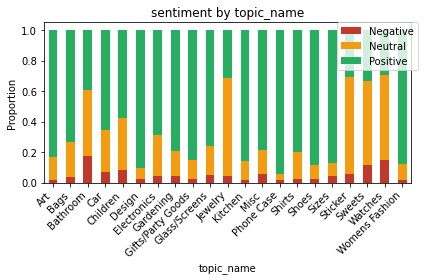

<module 'matplotlib.pyplot' from '/Users/liamgeron/anaconda3/envs/quility/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [32]:
colors = {'Positive': '#27AE60', 'Negative': '#C0392B', 'Neutral': '#F39C12'}

plot_grouped_categorical_distribution(sample, 'topic_name', 'sentiment', colors=colors)

# Modeling

First, in order to use price features I needed to build a regression model for imputation of the missing data. Specifically, price, discount and discount_pct. Then, I decided to see if I could predict the category of the text using the available extra data.

## Regression

In [135]:
sample_more_features = sample_more_features[sample_more_features.actual.notna()]

In [136]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

lr = LinearRegression()

In [137]:
scaler = StandardScaler()

In [138]:
subset = sample_more_features[sample_more_features['discount'].notna()]
to_predict = sample_more_features[sample_more_features['discount'].isna()]

In [139]:
subset.columns

Index(['product_id', 'product_type_id', 'product_length', 'main_category',
       'sub_category', 'ratings', 'no_of_ratings', 'discount_price',
       'actual_price', 'grouped_product_type_id', 'all_text', 'n_words',
       'n_unique_words', 'pct_unique_words', 'char_count', 'sum_word_len',
       'avg_word_len', 'ner', 'sentiment', 'sentiment_score', 'lda_topic',
       'lda_score', 'rating', 'n_ratings', 'discount', 'actual',
       'discount_pct', 'topic_name'],
      dtype='object')

In [140]:
X = scaler.fit_transform(subset[['actual']])
y = subset['discount']

In [141]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [142]:
lr.fit(X_train, y_train)

LinearRegression()

Coefficients: 
 [7661.20959061]
Mean squared error: 8056713.08
Coefficient of determination: 0.91


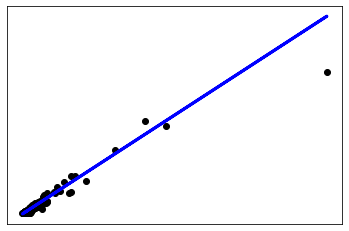

In [144]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = lr.predict(X_val)

# The coefficients
print("Coefficients: \n", lr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_val, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_val, y_pred))

# Plot outputs
plt.scatter(X_val, y_val, color="black")
plt.plot(X_val, y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [153]:
# Replace null discounts with regression

full_regression = LinearRegression().fit(X, y)
all_discounts = full_regression.predict(scaler.transform(sample_more_features.actual.values.reshape(-1, 1)))
sample_more_features['predicted_discount'] = all_discounts
sample_more_features['discount'] = sample_more_features.discount.fillna(sample_more_features.predicted_discount)
sample_more_features['discount_pct'] = ((sample_more_features['actual'] - sample_more_features['discount']) / sample_more_features['actual']) * 100

/Users/liamgeron/anaconda3/envs/quility/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/h7/xlk9rzkj7_74dkwlzx1fhhqm0000gn/T/ipykernel_89419/1768867829.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_more_features['predicted_discount'] = all_discounts
/var/folders/h7/xlk9rzkj7_74dkwlzx1fhhqm0000gn/T/ipykernel_89419/1768867829.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

## Classification

In [155]:
numerical_cols = [
    'product_length',
    'n_unique_words',
    'pct_unique_words',
    'char_count',
    'avg_word_len',
    'sentiment_score',
    'discount',
    'actual',
]

text_col = 'all_text'

In [156]:
preprocessing = ColumnTransformer(
    [
        ('text', TfidfVectorizer(), text_col),
        ('numerical', MinMaxScaler(feature_range=(0, 1)), numerical_cols)
    ]
)

In [157]:
ohe = OneHotEncoder()
tfidf = TfidfVectorizer()
le = LabelEncoder()

X = preprocessing.fit_transform(sample_more_features).toarray()
y = le.fit_transform(sample_more_features.main_category.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Hyperparameter Tuning

Using Bayesian Optimization

In [12]:
from sklearn import metrics, model_selection, ensemble
from functools import partial

from skopt import space
from skopt import gp_minimize

def optimize(params, param_names, x, y):
    params = dict(zip(param_names, params))
    clf = ensemble.RandomForestClassifier(**params) # Or any model you want
    kf = model_selection.StratifiedKFold(n_splits=5)
    accuracies = []
    for idx in kf.split(X=x, y=y):
        train_idx, test_idx = idx[0], idx[1]
        x_train = x[train_idx]
        y_train = y[train_idx]

        x_test = x[test_idx]
        y_test = y[test_idx]

        clf.fit(x_train, y_train)
        preds = clf.predict(x_test)
        fold_acc = metrics.f1_score(y_test, preds, average='macro')
        accuracies.append(fold_acc)

    return -1.0 * np.mean(accuracies) # Because we are going to minimize this function

param_space = [
    space.Integer(3, 15, name="max_depth"),
    space.Integer(100, 600, name="n_estimators"),
    space.Real(0.01, 1, prior="uniform", name="max_features")
]
param_names = [
    "max_depth",
    "n_estimators",
    "max_features"
]

optimization_function = partial(
    optimize,
    param_names = param_names,
    x=X_train,
    y=y_train
)

result = gp_minimize(
    optimization_function,
    dimensions=param_space,
    n_calls=15,
    n_random_starts=10,
    verbose=10
)

print(dict(zip(
    param_names,
    result.x
)))

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2662.2555
Function value obtained: -0.2571
Current minimum: -0.2571
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3976.6178
Function value obtained: -0.2888
Current minimum: -0.2888
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1014.3157
Function value obtained: -0.3790
Current minimum: -0.3790
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1172.2538
Function value obtained: -0.2022
Current minimum: -0.3790
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 3879.8063
Function value obtained: -0.3745
Current minimum: -0.3790
Iteration 

In [160]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=15, n_estimators=223, max_features=0.7605307413426079)

In [161]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=0.7605307413426079,
                       n_estimators=223)

In [162]:
preds = model.predict(X_test)

In [163]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.54      0.95      0.69       152
           1       0.74      0.71      0.72        48
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00        22
           4       0.67      0.62      0.65        16
           5       0.00      0.00      0.00        10
           6       0.52      0.48      0.50        29
           7       0.00      0.00      0.00         6
           8       1.00      0.13      0.24        15
           9       0.88      0.84      0.85        67
          10       0.76      0.82      0.79        67
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         1
          13       0.67      0.17      0.27        12
          14       0.75      0.46      0.57        39
          15       1.00      1.00      1.00         5
          16       0.83      0.79      0.81        43
          17       0.90    

/Users/liamgeron/anaconda3/envs/quility/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liamgeron/anaconda3/envs/quility/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liamgeron/anaconda3/envs/quility/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [185]:
feature_names = preprocessing.get_feature_names_out()
feature_importances = pd.DataFrame({'feature': feature_names,
                                    'importance': model.feature_importances_})

In [186]:
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

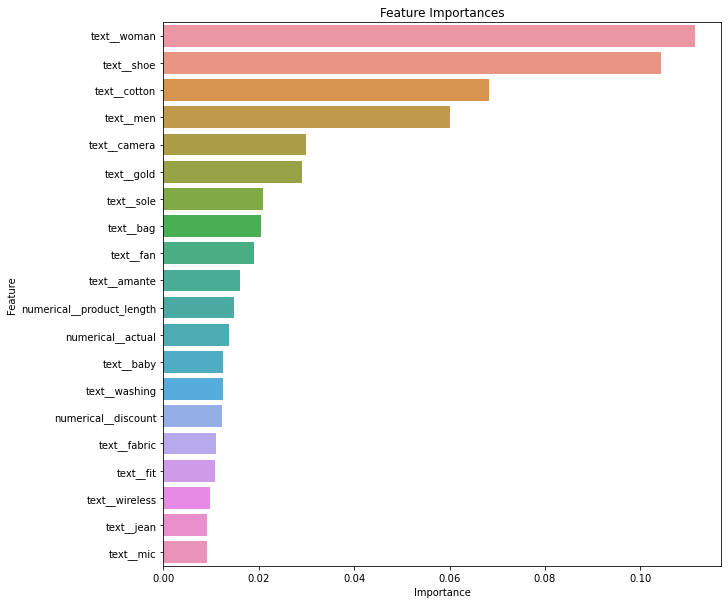

In [191]:
# Plot the feature importances
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feature_importances[:20])
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()